In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, InputLayer, Flatten, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from  matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import DenseNet121, ResNet50
from keras.layers import Conv2D, MaxPooling2D
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
batch_size = 16
img_height = 299
img_width = 299
image_size = (img_height, img_width)

In [3]:
data_dir1 = "/content/drive/MyDrive/Colab Notebooks/Major/Data/train"
data_dir2 = "/content/drive/MyDrive/Colab Notebooks/Major/Data/val"
data_dir3 = "/content/drive/MyDrive/Colab Notebooks/Major/Data/test"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir1,
  validation_split=None,
  shuffle=True,
  image_size=(img_height, img_width),
  subset=None,
  seed=123,
  batch_size=batch_size,
  label_mode='categorical'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir2,
  validation_split=None,
  shuffle=True,
  image_size=(img_height, img_width),
  subset=None,
  seed=123,
  batch_size=batch_size,
  label_mode='categorical'
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir3,
  shuffle=False,
  image_size=(img_height, img_width),
  label_mode='categorical'
)

Found 11447 files belonging to 5 classes.
Found 2445 files belonging to 5 classes.
Found 2445 files belonging to 5 classes.


In [8]:
resnet_base = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3),
    pooling='avg'
)
output = Dense(5, activation='softmax')(resnet_base.output)

resnet = Model(inputs=resnet_base.input, outputs=output)

In [5]:
# --- didnt work, bad results
# resnet.compile(
#     loss='categorical_crossentropy',
#     optimizer='adam',
#     metrics=['categorical_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
# )


**just revising concepts**
A metric is a function that is used to judge the performance of your model. Metric functions are similar to loss functions, except that the results from evaluating a metric are not used when training the model. Note that you may use any loss function as a metric.

In [9]:

resnet.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['binary_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)


In [10]:
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.1, min_lr=0.000001)

checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/Major/Models/resnet-best1.hdf5', save_best_only=True, verbose=True)

callbacks_list = [ early, learning_rate_reduction, checkpoint]

In [11]:

resnet_history = resnet.fit(
    train_ds,
    epochs=30,
    shuffle=True,
    validation_data=val_ds  ,
    callbacks=callbacks_list
)


Epoch 1/30
716/716 [==============================] - 266s 364ms/step - loss: 0.1176 - binary_accuracy: 0.9587 - precision_1: 0.9031 - recall_1: 0.8889 - val_loss: 1.2525 - val_binary_accuracy: 0.7349 - val_precision_1: 0.3362 - val_recall_1: 0.3342

Epoch 00001: val_loss improved from inf to 1.25248, saving model to /content/drive/MyDrive/Colab Notebooks/Major/Models/resnet-best1.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
716/716 [==============================] - 260s 363ms/step - loss: 0.0583 - binary_accuracy: 0.9811 - precision_1: 0.9543 - recall_1: 0.9513 - val_loss: 1.9637 - val_binary_accuracy: 0.7336 - val_precision_1: 0.3339 - val_recall_1: 0.3337

Epoch 00002: val_loss did not improve from 1.25248
Epoch 3/30
716/716 [==============================] - 260s 362ms/step - loss: 0.0465 - binary_accuracy: 0.9849 - precision_1: 0.9626 - recall_1: 0.9616 - val_loss: 3.2292 - val_binary_accuracy: 0.7081 - val_precision_1: 0.2700 - val_recall_1: 0.2699

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00003: val_loss did not improve from 1.25248
Epoch 4/30
716/716 [==============================] - 260s 362ms/step - loss: 0.0184 - binary_accuracy: 0.9945 - precision_1: 0.9864 - recall_1: 0.9859 - val_loss: 0.1983 - val_binary_accuracy: 0.9398 - val_precision_1: 0.8498 - val_recall_1: 0.8491

Epoch 00004: val_loss improved from 1.25248 to 0.19827, saving 

In [12]:
!ls "/content/drive/MyDrive/Colab Notebooks/Major/Data/train/Normal" | wc -l

2294


In [13]:
test_accu = resnet.evaluate(test_ds)
print('The testing accuracy is :',test_accu[1]*100, '%')

77/77 [==============================] - 357s 5s/step - loss: 0.0193 - binary_accuracy: 0.9953 - precision_1: 0.9881 - recall_1: 0.9881
The testing accuracy is : 99.52555894851685 %


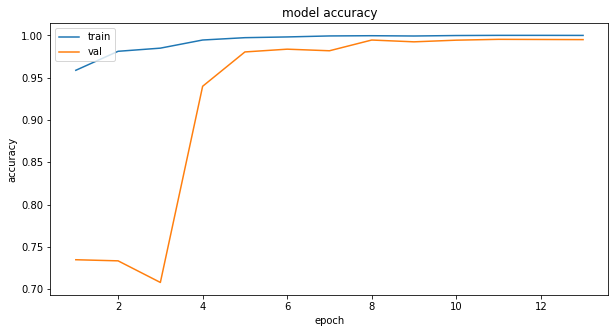

In [14]:
plt.figure(figsize=(10,5))
epochs=range(1,len(resnet_history.history['val_binary_accuracy'])+1)

plt.plot(epochs,resnet_history.history["binary_accuracy"])
plt.plot(epochs,resnet_history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

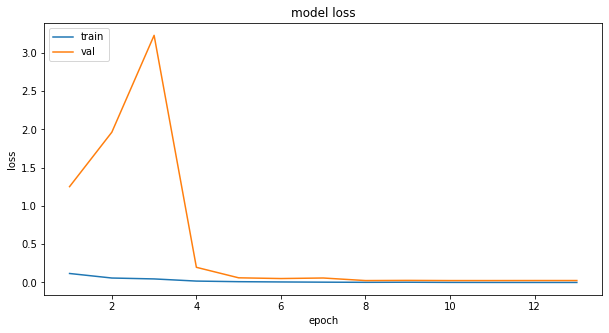

In [15]:
plt.figure(figsize=(10,5))
epochs=range(1,len(resnet_history.history['val_loss'])+1)

plt.plot(epochs,resnet_history.history["loss"])
plt.plot(epochs,resnet_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [17]:
pred = resnet.predict(test_ds,verbose=1)

77/77 [==============================] - 13s 156ms/step


In [18]:
prediction =np.argmax(pred,axis=1)

true_categories = tf.concat([y for x, y in test_ds], axis=0)
tc = np.argmax(true_categories,axis=1)

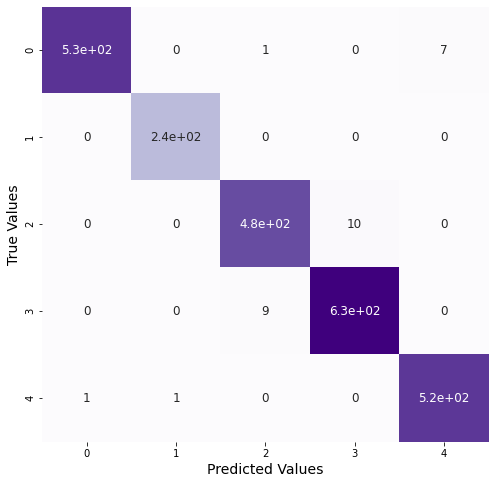

In [19]:
cm = confusion_matrix(tc, prediction)
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(1,1,1)
sns.set(font_scale=1.4) #for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 12},
     cbar = False, cmap='Purples');
ax1.set_ylabel('True Values',fontsize=14)
ax1.set_xlabel('Predicted Values',fontsize=14)
plt.show()